<a target="_blank" href="https://colab.research.google.com/github/thierrymoudiki/sktime/blob/nnetsauce-mts/examples/nnetsauce/2024-09-22-nnetsauce-MTS-example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip uninstall sktime -y

In [2]:
!pip install git+https://github.com/thierrymoudiki/sktime.git@nnetsauce-mts --upgrade --no-cache-dir

  Cloning https://github.com/thierrymoudiki/sktime.git (to revision nnetsauce-mts) to /tmp/pip-req-build-06urkdik
  Running command git clone --filter=blob:none --quiet https://github.com/thierrymoudiki/sktime.git /tmp/pip-req-build-06urkdik
  Running command git checkout -b nnetsauce-mts --track origin/nnetsauce-mts
  Switched to a new branch 'nnetsauce-mts'
  Branch 'nnetsauce-mts' set up to track remote branch 'nnetsauce-mts' from 'origin'.
  Resolved https://github.com/thierrymoudiki/sktime.git to commit b6248e1c500f0977af6522b18129e52b1aa9b5d3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.6/178.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 139.7 MB/s eta 0:00:00
  Created wheel for sktime: filename=sktime-0.32.1-py3-none-any.whl s

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.tsa.base.datetools import dates_from_str

from sktime.forecasting.nnetsaucemts import MTS

In [4]:
# some example data
mdata = sm.datasets.macrodata.load_pandas().data
# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgovt', 'tbilrate', 'cpi']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()

n = data.shape[0]
max_idx_train = np.floor(n*0.9)
training_index = np.arange(0, max_idx_train)
testing_index = np.arange(max_idx_train, n)
df_train = data.iloc[training_index,:]
print(df_train.tail())
df_test = data.iloc[testing_index,:]

            realgovt  tbilrate  cpi
2003-06-30      0.05     -0.17 0.00
2003-09-30      0.00     -0.02 0.01
2003-12-31      0.01     -0.04 0.01
2004-03-31      0.01      0.04 0.01
2004-06-30      0.01      0.25 0.01


In [5]:
# Adjust Ridge
regr = linear_model.Ridge()
obj_MTS = MTS(regr,
              lags = 25,
              a = 0.1,
              n_hidden_features=5,
              verbose = 1,
              type_pi="gaussian"
              )
display(obj_MTS.get_params())

{'a': 0.1,
 'activation_name': 'relu',
 'agg': 'mean',
 'backend': 'cpu',
 'bias': True,
 'block_size': None,
 'cluster_encode': True,
 'direct_link': True,
 'dropout': 0,
 'kernel': 'gaussian',
 'lags': 25,
 'n_clusters': 2,
 'n_hidden_features': 5,
 'nodes_sim': 'sobol',
 'obj': Ridge(),
 'replications': None,
 'seed': 123,
 'show_progress': True,
 'type_clust': 'kmeans',
 'type_pi': 'gaussian',
 'type_scaling': ('std', 'std', 'std'),
 'verbose': 1,
 'obj__alpha': 1.0,
 'obj__copy_X': True,
 'obj__fit_intercept': True,
 'obj__max_iter': None,
 'obj__positive': False,
 'obj__random_state': None,
 'obj__solver': 'auto',
 'obj__tol': 0.0001}

In [6]:
obj_MTS.fit(df_train)


 Adjusting Ridge to multivariate time series... 
 


100%|██████████| 3/3 [00:00<00:00, 55.22it/s]


MTS(a=0.1, lags=25, obj=Ridge(), type_pi='gaussian', verbose=1)

In [13]:
res = obj_MTS.predict(fh=[i for i in range(1, 10)])
print(res)

            realgovt  tbilrate  cpi
date                               
2004-09-30      0.01      0.12 0.01
2004-12-31      0.02      0.01 0.02
2005-03-31      0.00      0.23 0.01
2005-06-30     -0.00      0.11 0.02
2005-09-30      0.02      0.11 0.02
2005-12-31      0.01      0.15 0.02
2006-03-31     -0.00     -0.04 0.02
2006-06-30      0.01      0.06 0.02
2006-09-30      0.01      0.05 0.02


In [14]:
res = obj_MTS.predict_quantiles(fh=[i for i in range(1, 10)], alpha=0.05)
print(res)

           realgovt tbilrate  cpi realgovt tbilrate  cpi
               0.05     0.05 0.05     0.95     0.95 0.95
date                                                    
2004-09-30    -0.01    -0.06 0.00     0.04     0.31 0.02
2004-12-31    -0.00    -0.18 0.01     0.05     0.19 0.02
2005-03-31    -0.02     0.05 0.01     0.03     0.41 0.02
2005-06-30    -0.03    -0.07 0.01     0.02     0.30 0.02
2005-09-30    -0.01    -0.07 0.01     0.04     0.29 0.02
2005-12-31    -0.02    -0.04 0.02     0.04     0.33 0.03
2006-03-31    -0.03    -0.22 0.01     0.02     0.15 0.02
2006-06-30    -0.02    -0.13 0.01     0.03     0.24 0.03
2006-09-30    -0.02    -0.13 0.01     0.03     0.23 0.03


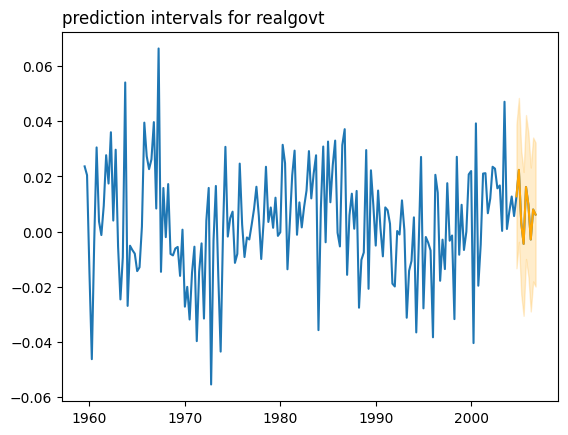

In [15]:
obj_MTS.fitter.plot(series="realgovt")

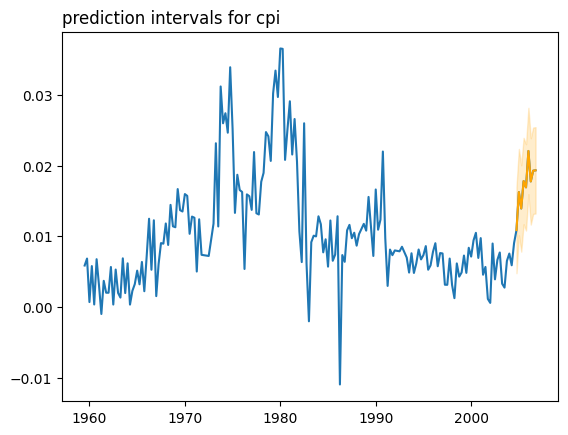

In [16]:
obj_MTS.fitter.plot(series="cpi")